# Essai avec une approche bootstrap

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import chisquare , distributions, power_divergence
import random

## Importation, analyse et nettoyage des données

In [2]:
data = pd.read_csv("1512006-Calbicans-QUANTI_raw_abundance.csv", sep=",", header=None)
print(data.shape)
data.head(3)

(2356, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,9.325899e+04,2.765206e+04,6.973654e+04,6.309967e+04,2.252522e+04,5.307728e+04,9.088306e+04,2.035561e+04,0.000000e+00,0.000000e+00,1.021926e+05,1.794098e+05
1,5.042612e+07,1.592204e+07,4.388571e+07,1.824970e+07,1.596605e+07,1.566419e+07,2.563818e+07,2.666071e+07,1.431299e+07,2.617207e+07,2.847710e+07,4.051467e+07
2,0.000000e+00,0.000000e+00,6.015709e+03,2.413695e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.132027e+03,4.891291e+04,2.974154e+04,4.261914e+04


In [3]:
# données dans un array d'une dimmenssion
exp_numbers = data.values.reshape(data.shape[0]*data.shape[1])
print(exp_numbers.shape)

(28272,)


In [4]:
# Remove 0
exp_numbers = exp_numbers[ exp_numbers > 0 ]
exp_numbers.shape

(26936,)

## loi de Benford
fréquence de la loi de benford

In [5]:
freq_benford = np.zeros(9, dtype=float)
for i in range(9):
    freq_benford[i] = (math.log((1+(1/(i+1))), 10))
print(freq_benford)
sum(freq_benford)

[0.30103    0.17609126 0.12493874 0.09691001 0.07918125 0.06694679
 0.05799195 0.05115252 0.04575749]


0.9999999999999999

## First digit

In [6]:
first_digit = np.zeros(9, dtype=int)
for a in range(0, data.shape[1]):
    for x in data[a]:
        first = int(str(x)[0])
        if first == 0:
            continue
        first_digit[first-1] += 1
print(first_digit)
print(sum(first_digit))

[7942 4691 3273 2642 2176 1885 1638 1390 1282]
26919


## Normalisation

In [7]:
first_digit_norm = np.array(first_digit /  sum(first_digit))
print(first_digit_norm)
print(sum(first_digit_norm))
print(first_digit)

[0.29503325 0.17426353 0.12158698 0.09814629 0.0808351  0.07002489
 0.06084921 0.05163639 0.04762435]
1.0
[7942 4691 3273 2642 2176 1885 1638 1390 1282]


## Barplot de la fréquence des first digit de l'abondance des protéines et de la loi de Benford

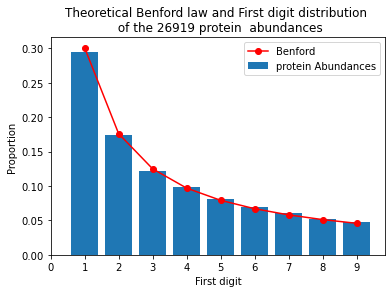

In [8]:
plt.plot(range(1,10), freq_benford, marker="o", color="red")
plt.bar(range(1,10), first_digit_norm)
plt.xticks(ticks=range(0,10))
plt.title(label=f"Theoretical Benford law and First digit distribution \n of the {sum(first_digit)} protein  abundances")
plt.xlabel("First digit")
plt.ylabel("Proportion")
plt.legend(labels = ("Benford", "protein Abundances"));

# procédure "bootstrap"
## Fonction First digit

In [9]:
def first_digit(data):
    """ Distribution des first digit des données
    
    Fonction permettant de renvoyer la distribution des first digit d'un jeu
    de données.
    
    Parameters
    ¯¯¯¯¯¯¯¯¯¯
    data : array of int
        Array d'entiers.
    
    Returns
    ¯¯¯¯¯¯¯
    fd : array
        Distribution des first digit.
    """
    fd = np.zeros(9, dtype=int)
    for x in range(len(data)):
        first = int(str(data[x])[0])
        fd[first-1] += 1
    return fd

## Fonction de moyenne des $\chi^2$

In [10]:
def meanchi2(data_obs, freq_theo, nb_val, nb_loop, type_test):
    """ Moyenne des chi2 calculés.
    
    Fonction permettant de calculer la moyennes des chi2.
    
    parameters
    ¯¯¯¯¯¯¯¯¯¯
    data_obs : array of int
        Array d'entiers des données obsevés.
    freq_theo : array of float
        Array de float des fréquences théoriques.
    nb_val : int
        Nombre de d'individu par échantillon.
    nb_loop : int
        nombre de fois que l'on réalise la procédure de "bootstrap".
    
    Returns
    ¯¯¯¯¯¯¯
    float
        La moyenne des chi2 du "bootstrap".
    """
    sumChi2 = np.zeros(nb_loop, dtype=float)
    d_theo = np.array(freq_theo * nb_val)
    for i in range(nb_loop):
        ech = np.random.choice(data_obs, size=nb_val, replace=False)
        d_obs = first_digit(ech)
        sumChi2[i] = power_divergence(f_obs=d_obs, f_exp=d_theo, lambda_=type_test)[0]
    return (sum(sumChi2) / nb_loop)

## Fonction principale de la procédure "bootstrap"

In [11]:
def bootstrap_chi2(data_obs, freq_theo, nb_val, nb_loop, type_test):
    """ Moyenne des chi2 calculés et sa p-value associé."¶
    
    Fonction permettant de calculer la moyenne des chi2 et sa p-value associé.
    
    parameters
    ¯¯¯¯¯¯¯¯¯¯
    data_obs : array of int
        Array d'entiers des données obsevés.
    freq_theo : array of float
        Array de float des fréquences théoriques.
    nb_val : int
        Nombre de d'individu par échantillon.
    nb_loop : int
        nombre de fois que l'on réalise la procédure de "bootstrap".
    
    Returns
    ¯¯¯¯¯¯¯
    p_val : float
        p-value de mean_chi2
    mean_chi2 : float
        La moyenne des chi2 du "bootstrap". 
    """
    k = len(freq_theo+1)
    mean_chi2 = meanchi2(data_obs, freq_theo, nb_val, nb_loop, type_test)
    p_val = distributions.chi2.sf(mean_chi2, k - 1)
    return p_val, mean_chi2

In [12]:
bootstrap_chi2(exp_numbers, freq_benford, 1000, 1000, 1) #chi2

(0.3915053814707626, 8.44223043460079)

In [15]:
%%time
bootstrap_chi2(exp_numbers, freq_benford, 1000, 1000, 0) #G-test

CPU times: user 2.24 s, sys: 15.8 ms, total: 2.26 s
Wall time: 2.27 s


(0.3750956691576457, 8.622934867487052)

## conclusion

La procédure mise en place ("bootstrap") permet de montrer, por un rique alpha de 5%, que les données expérimentale d'abondances de protéines suivent ici la loi de Benford. Puisque la p-value obtenu est supérieur à 5%, on ne rejette pas l'hypothése $H_0$, donc la distribution théorique suit la loi Beford.

# Évolution de la moyenne des $\chi^2$ en fonction de la taille de l'échantillon

Cette partie va nous permettrer de déteriner et de fixer une taille d'échanitllon lors de la procédure "bootstrap", que l'on utilisera ensuite dans l'ensemble des annalyses d'existence de la loi de Benford dans des données biologiques.

In [17]:
sample_size_list = list(range(200, 1000, 100)) + list(range(1000, 5000, 500)) + list(range(5000, 25001, 1000))

In [19]:
%%time
mean_chi2_list = []
p_val_list = []
for sample_size in sample_size_list:
    p_val, mean_chi2 = bootstrap_chi2(exp_numbers, freq_benford, sample_size, 1000, 1)
    p_val_list.append(p_val)
    mean_chi2_list.append(mean_chi2)
    print(sample_size, p_val, mean_chi2)

200 0.42179364716081014 8.120449462157035
300 0.4308886009131748 8.026471301622124
400 0.406214631519683 8.284178159594918
500 0.397946823910602 8.372581377829414
600 0.40569353848154777 8.289717914784298
700 0.38644437884337873 8.497449071658936
800 0.39264230113947657 8.42988662673437
900 0.3794220995281978 8.574817832530588
1000 0.3896412760506654 8.462517322429413
1500 0.36989318930777687 8.681265640307263
2000 0.35356714812337803 8.867841709297956
2500 0.3191763690985764 9.280654521443493
3000 0.3083586190169026 9.416863032380574
3500 0.2924372797523051 9.623688020130292
4000 0.27743861820919447 9.82617754510901
4500 0.26492520112965134 10.001435147508351
5000 0.26684502140040134 9.97414884549786
6000 0.21416701739103053 10.785243549758503
7000 0.22555249500537009 10.597692578615101
8000 0.1870855250723424 11.265858252334516
9000 0.16297730310246028 11.744406981346318
10000 0.14474251414660913 12.14751449582869
11000 0.13381800079660883 12.410216630031233
12000 0.10296598069841975

In [20]:
len(exp_numbers)

26936

# Évolution de la moyenne des statistics du G-test en fonction de la taille de l'échantillon

In [21]:
%%time
mean_gstat_list = []
p_val_g_list = []
for sample_size in sample_size_list:
    p_val, mean_gstat = bootstrap_chi2(exp_numbers, freq_benford, sample_size, 1000, 0)
    p_val_g_list.append(p_val)
    mean_gstat_list.append(mean_gstat)
    print(sample_size, p_val, mean_gstat)

200 0.4260883708936866 8.075930683905266
300 0.41681729261318506 8.172359968731422
400 0.40593594136574057 8.287140395919083
500 0.4032174088040507 8.316099923922753
600 0.40688662363037004 8.277040431319989
700 0.3878369104700715 8.482211260952003
800 0.40701838619614117 8.275641704938463
900 0.3881648601424659 8.478627606527596
1000 0.388746986191417 8.472271070330402
1500 0.36603599176787915 8.724854266125186
2000 0.3527882989248756 8.876882695614697
2500 0.32786919577306417 9.173533088130107
3000 0.3207971081310716 9.2605290803638
3500 0.3107861284038293 9.386006623098584
4000 0.2751614925151315 9.857623351339035
4500 0.28045376919557213 9.784833913705102
5000 0.2738777223132228 9.875437084560781
6000 0.24476984185079345 10.29739736048963
7000 0.20108244885704163 11.010898326875976
8000 0.1940042805475264 11.137956155506417
9000 0.16312476055200337 11.74130566866902
10000 0.14863042511728025 12.058098731484819
11000 0.14036284741396704 12.250724892124804
12000 0.12896720313919216 1

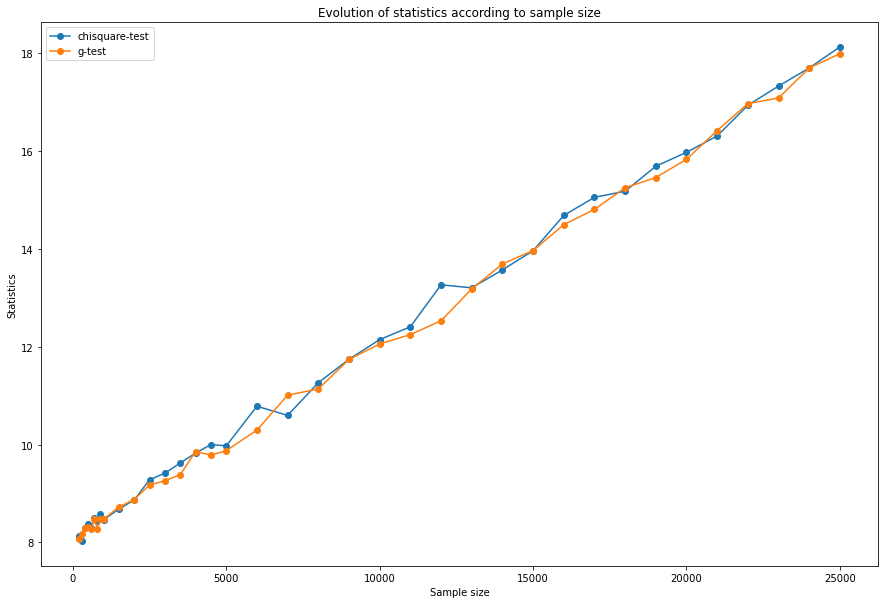

In [22]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_list, mean_chi2_list, marker='o')
plt.plot(sample_size_list, mean_gstat_list, marker='o')
plt.title("Evolution of statistics according to sample size")
plt.ylabel("Statistics")
plt.xlabel("Sample size")
plt.legend(labels=("chisquare-test", "g-test"));

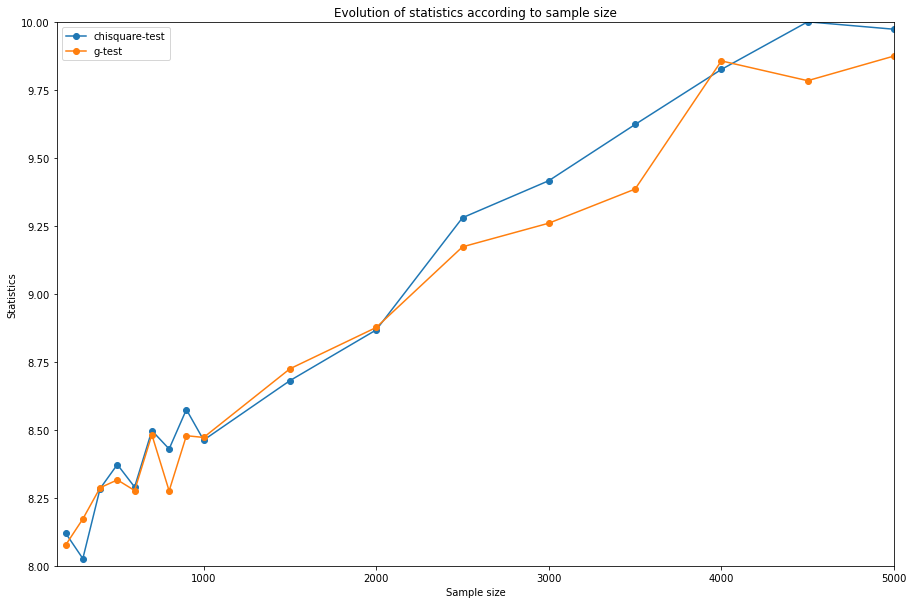

In [23]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_list, mean_chi2_list, marker='o')
plt.plot(sample_size_list, mean_gstat_list, marker='o')
plt.xlim(left=150, right=5000)
plt.ylim(bottom=8, top=10)
plt.title("Evolution of statistics according to sample size")
plt.ylabel("Statistics")
plt.xlabel("Sample size")
plt.legend(labels=("chisquare-test", "g-test"));

In [25]:
mean_chi2_list_log = np.log10(np.array(mean_chi2_list))
mean_gstat_list_log = np.log10(np.array(mean_gstat_list))
sample_size_log = np.log10(np.array(sample_size_list))
"""
print(mean_chi2_list_log)
print(mean_gstat_list_log)
print(sample_size_log)
""";

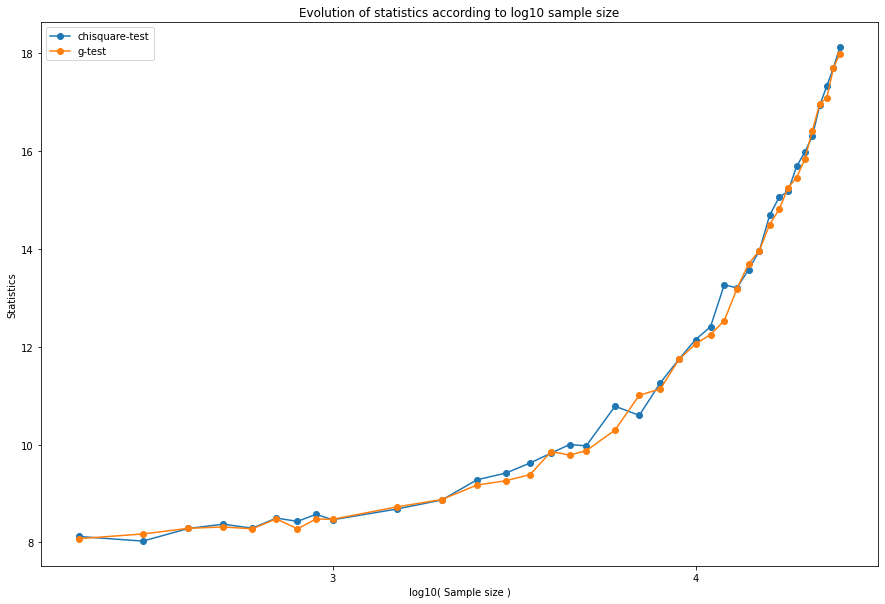

In [30]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_log, mean_chi2_list, marker='o')
plt.plot(sample_size_log, mean_gstat_list, marker='o')
plt.title("Evolution of statistics according to log10 sample size")
plt.ylabel("Statistics")
plt.xlabel("log10( Sample size )")
plt.xticks(ticks=[3,4],labels=["3","4"])
plt.legend(labels=("chisquare-test", "g-test"));
plt.savefig("statistics_evolution.png",transparent=True)

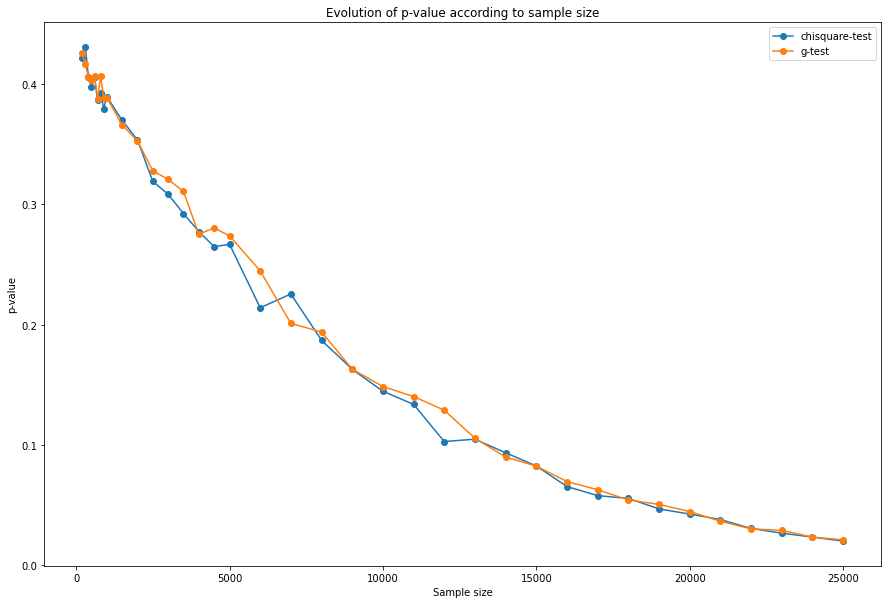

In [27]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_list, p_val_list, marker='o')
plt.plot(sample_size_list, p_val_g_list, marker='o')
plt.title("Evolution of p-value according to sample size")
plt.ylabel("p-value")
plt.xlabel("Sample size")
plt.legend(labels=("chisquare-test", "g-test"));

In [28]:
p_val_list_log = -np.log10(np.array(p_val_list))
p_val_g_list_log = -np.log10(np.array(p_val_g_list))
"""
print(p_val_list_log)
print(p_val_g_list_log)
""";

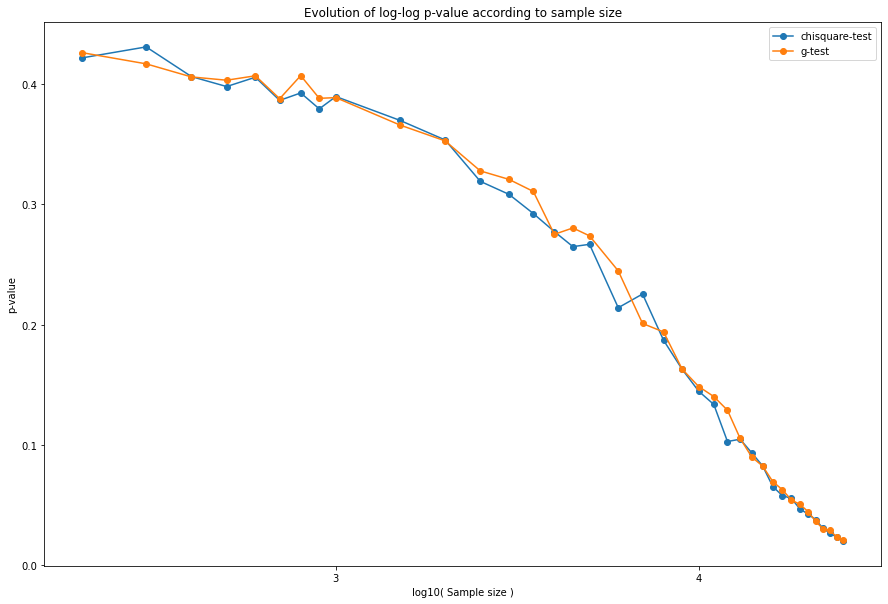

In [29]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_log, p_val_list, marker='o')
plt.plot(sample_size_log, p_val_g_list, marker='o')
plt.title("Evolution of log-log p-value according to sample size")
plt.ylabel("p-value")
plt.xlabel("log10( Sample size )")
plt.xticks(ticks=[3,4],labels=["3","4"])
plt.legend(labels=("chisquare-test", "g-test"));